In [2]:
###
# Idea for pretty art from images. 
# image is gaussian blurred into a potential, 
#lines emerge from edges and are attracted to the image basin. Lines per channel 

In [9]:
import os
import numpy as np
import imageio
from PIL import Image
from matplotlib import pyplot as plt
from scipy import interpolate

from math import sqrt, pow, cos, sin, pi
import copy, pickle, random

%matplotlib inline

In [10]:
import svgwrite

In [11]:
files = os.listdir('/Users/johnparkhill/Little_Projects/art_for_lines')

In [12]:
rootdir = '/Users/johnparkhill/Little_Projects/art_for_lines/'
im_arrays=[]
for X in files: 
    if X.count("jpg")>0: 
        with open(rootdir+X,'rb') as f: 
            im_arrays.append(imageio.imread(f))

In [13]:
files

['.DS_Store',
 '81E3dK1i3-L._SL1500_.jpg',
 'CE3_stepper_motor_mount.3mf',
 'stalker-1979-002-00m-ln4-dog-running-through-water_0.jpg',
 'gokudo-kyofu-dai-gekijo-gozu-german-dvd-movie-cover.jpg',
 '23405756_1890470151282571_8743520120236682996_o.jpg',
 'stalkerlines.pkl',
 'e62edc39b7fafd0edf295b833bbcc5a3.jpg',
 'images-w1400.jpg',
 'LDurieux_Conversation_Var_Sm_1024x1024.png',
 'img_1298.jpg']

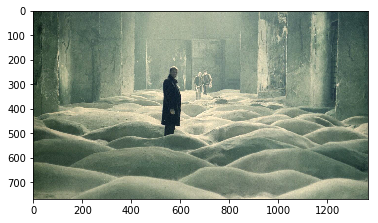

In [50]:
img = im_arrays[-1]
plt.imshow(img)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


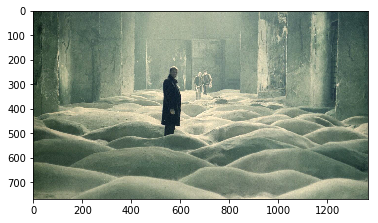

In [52]:
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
#
# 2x oversample the image since we'll dither it. 
#
oversamp = 1.0
xnew = np.linspace(0, img.shape[0], img.shape[0]*oversamp)
ynew = np.linspace(0, img.shape[1], img.shape[1]*oversamp)
rc = interpolate.interp2d(x, y, img[:,:,0].flatten(), kind='linear')
gc = interpolate.interp2d(x, y, img[:,:,1].flatten(), kind='linear')
bc = interpolate.interp2d(x, y, img[:,:,2].flatten(), kind='linear')
rgb_new = np.stack([rc(xnew.flatten(), ynew.flatten()),
                    gc(xnew.flatten(), ynew.flatten()),
                    bc(xnew.flatten(), ynew.flatten())],-1).transpose(1,0,2).astype(np.uint8)
plt.imshow(rgb_new)

In [54]:
def floyd_steinberg(X, mx=255., alg = 'stucki'):
    """
    output is 1 or zero. 
    """
    rank = len(X.shape)
    if (rank==2):
        out = np.zeros((X.shape[0]+4, X.shape[1]+4))
    elif (rank==3):
        out = np.zeros((X.shape[0]+4, X.shape[1]+4, X.shape[2]))
    errors = np.zeros(out.shape)
    xdim = X.shape[0]
    ydim = X.shape[1]
    if (alg == 'stucki'):
        error_array = np.array([[0.,0.,0,8,4],[2.,4.,8,4,2],[1.,2.,4,2,1]])/42.
    else: 
        error_array = np.array([[0.,0.,0,1,1],[0.,1.,1,1,0],[0.,0.,1,0,0]])/8.
    for y in range(2,ydim+2):
        for x in range(2,xdim+2):
            div = X[x-2,y-2].astype(np.float64)/mx + errors[x,y] 
            output = np.round(div)
            error = div - output
            out[x,y] = output
            if (rank == 2):
                errors[x-2:x+3,y:y+3] += error * error_array.T
            else: 
                errors[x-2:x+3,y:y+3] += error * error_array[:,:,np.newaxis].transpose(1,0,2)
    return out[2:-2,2:-2]

def rgb_to_cmyk(X, RGB_SCALE = 255):
    CMYK_SCALE = 1.
    r = X[:,:,0].astype(np.float64)
    g = X[:,:,1].astype(np.float64)
    b = X[:,:,2].astype(np.float64)
    # rgb [0,255] -> cmy [0,1]
    c = 1. - r / RGB_SCALE
    m = 1. - g / RGB_SCALE
    y = 1. - b / RGB_SCALE
    # extract out k [0, 1]
    #     min_cmy = min(c, m, y)
    min_cmy = np.minimum(c, m)
    min_cmy = np.minimum(min_cmy, y)
    k = np.where(r+g+b == 0, 1., min_cmy)
    c = (c - min_cmy) / (1. - min_cmy+1e-9)
    m = (m - min_cmy) / (1. - min_cmy+1e-9)
    y = (y - min_cmy) / (1. - min_cmy+1e-9)
    # rescale to the range [0,CMYK_SCALE]
    return np.stack([c * CMYK_SCALE, y * CMYK_SCALE, m * CMYK_SCALE,  k * CMYK_SCALE], -1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


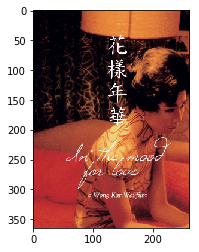

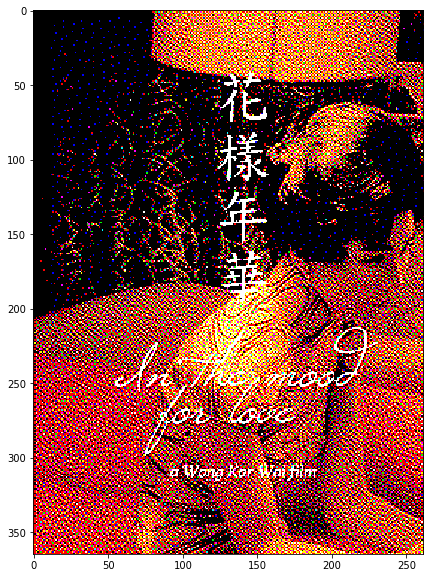

In [45]:
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
#
# 2x oversample the image since we'll dither it. 
#
oversamp = 0.5
xnew = np.linspace(0, img.shape[0], img.shape[0]*oversamp)
ynew = np.linspace(0, img.shape[1], img.shape[1]*oversamp)
rc = interpolate.interp2d(x, y, img[:,:,0].flatten(), kind='linear')
gc = interpolate.interp2d(x, y, img[:,:,1].flatten(), kind='linear')
bc = interpolate.interp2d(x, y, img[:,:,2].flatten(), kind='linear')
rgb_new = np.stack([rc(xnew.flatten(), ynew.flatten()),
                    gc(xnew.flatten(), ynew.flatten()),
                    bc(xnew.flatten(), ynew.flatten())],-1).transpose(1,0,2).astype(np.uint8)
plt.imshow(rgb_new)
# cymk_new = rgb_to_cymk(rgb_new)
dith_r = floyd_steinberg(rgb_new)
plt.figure(figsize=(8,10))
plt.imshow((255*dith_r).astype(np.uint8))

In [46]:
## Render a dithered image as polygons
def ngon(X=0, Y=0, r=1, n=6, phase = 0, closed = True):
    pts = []
    step = 2*pi/n
    for K in range(n): 
        pts.append([X+r*cos(K*step+phase),
                    Y+r*sin(K*step+phase)])
    if closed: 
        pts.append([X+r*cos(phase),
                    Y+r*sin(phase)])
    return pts

def random_ngon_linify(cymk_img, n_min=3, n_max=6, r_min = .1, r_max = 1.):
    """
    Draws ngons over a previously dithered image. 
    """
    c_lines, y_lines, m_lines, k_lines = [],[],[],[] 
    for X in range(cymk_img.shape[0]): 
        for Y in range(cymk_img.shape[1]): 
            if (cymk_img[X,Y,0]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                c_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))
            if (cymk_img[X,Y,1]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                y_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))
            if (cymk_img[X,Y,2]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                m_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))
            if (cymk_img[X,Y,3]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                k_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))                
    return c_lines, y_lines, m_lines, k_lines

In [47]:
dithered = floyd_steinberg(rgb_new)
# Because the dithered output is already between 0,1
cymk_new = rgb_to_cmyk(dithered, RGB_SCALE=1.)
c_lines, y_lines, m_lines, k_lines = random_ngon_linify(cymk_new)
cymk_lines = [c_lines, y_lines, m_lines, k_lines]

In [59]:
def write_svg(lines, outname="dump", scale = 1.0): 
    dwg = svgwrite.Drawing(outname+'.svg')
    for line in lines:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line(line[I][::-1], line[I+1][::-1], stroke=svgwrite.rgb(0, 0, 0, '%')))            
    dwg.save()
    
def cymk_to_svg(lines, outname="dump", scale = 1.0): 
    dwg = svgwrite.Drawing(outname+'.svg')
    for line in lines[0]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                             (scale*line[I+1][1],scale*line[I+1][0]),
                             stroke=svgwrite.rgb(0, 100, 100, '%')))
    for line in lines[1]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                            (scale*line[I+1][1],scale*line[I+1][0]),
                            stroke=svgwrite.rgb(100, 100, 0, '%')))
    for line in lines[2]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                            (scale*line[I+1][1],scale*line[I+1][0]), 
                             stroke=svgwrite.rgb(100, 0, 100, '%')))
    for line in lines[3]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                            (scale*line[I+1][1],scale*line[I+1][0]), 
                             stroke=svgwrite.rgb(0, 0, 0, '%')))
    dwg.save()

In [49]:
cymk_to_svg(cymk_lines,scale=5.)

In [ ]:
###
# Plot lines... WARNING SLOW. 

# plt.figure(figsize=(8,10))
# for line in c_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='cyan')
# for line in y_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='yellow')
# for line in m_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='magenta')
# for line in k_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='black')    
# plt.show()

In [1054]:
def snake_dither(X, mx=255., ntraj = 4000, max_step = 10000):
    rank = len(X.shape)
    pad = 2
    out = np.zeros((X.shape[0]+2*pad, X.shape[1]+2*pad))
    errors = np.zeros(out.shape)
    visited = np.zeros(out.shape)    
    xdim = X.shape[0]
    ydim = X.shape[1]
    error_array = np.array([[1,2,1],[2,0,2],[1,2,1]])/12.
    lines = []
    step=0
    x_lim = (pad,X.shape[0]+pad)
    y_lim = (pad,X.shape[1]+pad)    
    for traj in range(ntraj): 
        x = np.random.randint(pad,xdim+pad)
        y = np.random.randint(pad,ydim+pad)
        line = []
        while step < max_step:
            visited[x,y]=1
            div = X[x-pad,y-pad].astype(np.float64)/mx + errors[x,y] 
            output = np.round(div)
            error = div - output
            out[x,y] = output            
            errors[x-1:x+2,y-1:y+2] += error * error_array.T
            if (output):
                line.append([x,y])
            else: 
                break 
                
            dx = np.random.randint(-2,3)
            dy = np.random.randint(-2,3)
            while (dx==0 and dy==0):
                dx = np.random.randint(-2,3)
                dy = np.random.randint(-2,3)
            x+=dx
            y+=dy
            
            if (visited[x,y]):
                break 
            elif (x >= x_lim[1]): 
                break 
            elif (x <= x_lim[0]): 
                break  
            elif (y >= y_lim[1]): 
                break 
            elif (y <= y_lim[0]): 
                break
        lines.append(line)        
    return lines

In [1039]:
# cymk = rgb_to_cmyk(img)
# c_lines = snake_dither(cymk[:,:,0],mx=1.)
# y_lines = snake_dither(cymk[:,:,1],mx=1.)
# m_lines = snake_dither(cymk[:,:,2],mx=1.)
# k_lines = snake_dither(cymk[:,:,3],mx=1.)
# plt.figure(figsize=(10,10))
# for line in c_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='cyan')
# for line in y_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='yellow')
# for line in m_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='magenta')
# for line in k_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='black')    
# plt.show()

In [55]:
###
# Now send out the lines onto this potential wherever it's sampled. 

def grid_lineify(f, x_lim=(0.,256) ,y_lim=(0.,256), ntraj = 600, 
            max_step = 3000, gamma = 0.02, dt = 9., e0 = 0.1, 
            T = 0.1, 
            e_thresh = 0.001, h = 2e-1, m = 3, bounce = False
           ):
    """
    Units here are going to be pixel/sec.
    """
    lines = []
    nx = int(np.sqrt(ntraj))
    x_starts, y_starts = np.meshgrid(np.linspace(x_lim[0],x_lim[1],nx), 
                                     np.linspace(y_lim[0],y_lim[1],nx))
    x_starts = x_starts.flatten()
    y_starts = y_starts.flatten()
    for traj in range(len(x_starts)): 
        x,y = x_starts[traj].item(), y_starts[traj].item()
        PE = f(x, y)
        v0 = np.sqrt(e0/m)
        vx,vy = np.random.normal(0,v0), np.random.normal(0,v0)
        line = []
        step = 0        
        while step < max_step and np.sqrt(vx*vx+vy*vy) > e_thresh:     
            PE = f(x, y)
            if (np.exp(-PE/.01) > np.random.random()):
                break             
            # cdiff grad 
            gx = ((f(x+h,y)-f(x-h,y))/(2*h)).item()
            gy = ((f(x,y+h)-f(x,y-h))/(2*h)).item()
            vx += 0.5*dt*(gx - gamma*vx + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            vy += 0.5*dt*(gy - gamma*vy + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            x += vx*dt
            y += vy*dt
            # Bounce off edges. 
            if (bounce): 
                if (x > x_lim[1]): 
                    x -= 2.0*np.abs(x-x_lim[1])
                    vx *= -1
                if (x < x_lim[0]): 
                    x += 2.0*np.abs(x-x_lim[0])
                    vx *= -1 
                if (y > y_lim[1]): 
                    y -= 2.0*np.abs(y-y_lim[1])
                    vy *= -1
                if (y < y_lim[0]): 
                    y += 2.0*np.abs(y-y_lim[0])
                    vy *= -1
            else: # absorb
                if (x > x_lim[1]): 
                    break 
                elif (x < x_lim[0]): 
                    break  
                elif (y > y_lim[1]): 
                    break 
                elif (y < y_lim[0]): 
                    break                 
            line.append([x,y])
            gx = ((f(x+h,y)-f(x-h,y))/(2*h)).item()
            gy = ((f(x,y+h)-f(x,y-h))/(2*h)).item()
            vx += 0.5*dt*(gx - gamma*vx + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            vy += 0.5*dt*(gy - gamma*vy + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            step += 1
        lines.append(line)
    return lines 

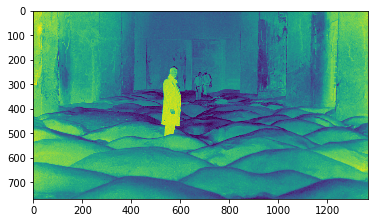

In [56]:
cymk = rgb_to_cmyk(img)
plt.imshow(cymk[:,:,-1])

In [57]:
cymk = rgb_to_cmyk(img)
# cc = interpolate.interp2d(x, y, cymk[:,:,0].flatten(), kind='linear')
# yc = interpolate.interp2d(x, y, cymk[:,:,1].flatten(), kind='linear')
# mc = interpolate.interp2d(x, y, cymk[:,:,2].flatten(), kind='linear')
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
kc = interpolate.interp2d(x, y, cymk[:,:,3].flatten(), kind='linear')
# c_lines = grid_lineify(cc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 1000)
# y_lines = grid_lineify(yc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 500)
# m_lines = grid_lineify(mc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 1000)
k_lines = grid_lineify(kc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]), 
            ntraj = 1500, 
            max_step = 4000, gamma = 0.08, dt = 9., e0 = 0.03, 
            T = 0.1, e_thresh = 0.006, h = 2e-1, m = 6, bounce = False)

In [61]:
with open("stalkerII",'wb') as f: 
    pickle.dump(k_lines,f)

In [60]:
write_svg(k_lines, scale=3.0)

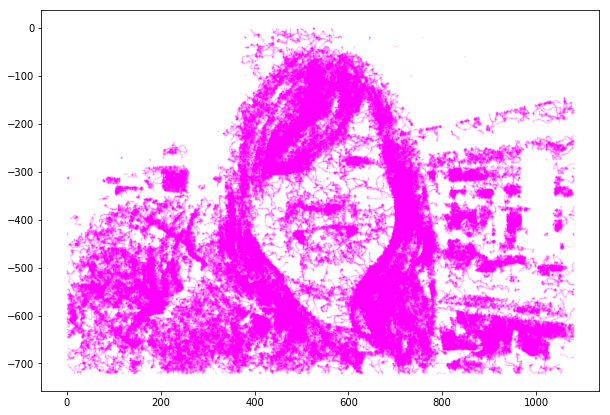

In [1117]:
plt.figure(figsize=(10,7))
# for line in c_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='cyan')
# for line in y_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='yellow')
# for line in m_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='magenta')
for line in k_lines: 
    if (len(line)<1):
        continue 
    t1 = np.array(line)
    _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.1, color='magenta')    
plt.show()

In [64]:
(10-12)%10

8

In [189]:
from math import sqrt, pow, cos, sin, pi
import copy, pickle, time, os
HAS_ADAF = False

if (HAS_ADAF):
    from adafruit_motorkit import MotorKit as MK
    from adafruit_motor import stepper
    from adafruit_servokit import ServoKit as SK
def sign(X): 
    if X>0: 
        return 1
    elif(X<0): 
        return -1 
    elif (X == 0): 
        return 0
def ngon(X=0, Y=0, r=1, n=6, phase = 0):
    pts = []
    step = 2*pi/n
    for K in range(n): 
        pts.append([X + r*cos(K*step+phase),
                    Y+r*sin(K*step+phase)])
    return pts
class Stepper:
    def __init__(self, ada_stepper, mock=True,
                step_delay = 0.02, step_per_rev = 200):
        self.step = ada_stepper
        self.mock = mock
        self.step_delay = step_delay
        self.step_per_rev = step_per_rev
        if (not mock): 
            self.CW = stepper.FORWARDS
            self.CCW = stepper.BACKWARDS
        self.odo = 0 
        self.step_pos = 0
        self.log = []
        return
    def CW(self,n=1):
        for k in range(n):
            self.odo += 1
            self.step_pos = self.odo % self.step_per_rev
            if (not self.mock):
                self.step.onestep(direction=self.CW)
            else: 
                self.log.append([time.time(), self.odo])
            time.sleep(self.step_delay)
    def CCW(self,n=1):
        for k in range(n):
            self.odo -= 1            
            self.step_pos = self.odo % self.step_per_rev
            if (not self.mock):
                self.step.onestep(direction=self.CCW)
            else: 
                self.log.append([time.time(), self.odo])            
            time.sleep(self.step_delay)
        return
class Lifter:
    def __init__(self, a_servo, mock=True):
        self.servo = a_servo
        self.mock = mock
        if (not self.mock): 
            self.servo.actuation_range = 160
            self.servo.angle = 0
        self.log = []            
        return 
    def up(self):
        if not self.mock: 
            self.servo.angle = 60
        else: 
            self.log.append([time.time(), 60.])
        time.sleep(0.3)            
        return 
    def down(self): 
        if not self.mock: 
            self.servo.angle = 0 
        else: 
            self.log.append([time.time(), 0.])
        time.sleep(0.3)
        return
class Plotter:
    def __init__(self, test=False): 
        """
        All units are cm, degrees, seconds, grams
        The top of the left cog is 0,0. 
        the top of the right cog is (cog_distance,0)
        
        Plotter must be initialized with the pen at the top, 
        center of the drawable area a distance y0 from the
        from the cog-tops. 
        
        The plotter adjusts lengths of left and right strings
        to achieve desired x,y. Resolution is limited 
        by the cog diameters (speed). 
        """
        self.log = []
        self.initialize()
        print("Print area: ", self.x_lim, self.y_lim)
        print("Step Lengt: ", self.step_dl)
        print("Min Resolu: ", (self.x_lim[1]-self.x_lim[0])//self.step_dl," X ",
                           (self.y_lim[1]-self.y_lim[0])//self.step_dl)
        if (test):
            self.plot_test()
        target_file = self.file_picker()
        self.plot_file(target_file)
        return
    def initialize(self, cog_distance = 91.44, 
                    bottom_edge = 59.2, 
                    steps_per_rev=200, cog_circum=5.*2*pi,
                    y0 = 2.
                  ): 
        self.cog_distance = cog_distance
        self.steps_per_rev = 200
        self.cog_circum = cog_circum
        self.step_dl = self.cog_circum/self.steps_per_rev
        self.chain_density = 0.5 # g/cm
        self.plumb_mass = 100 # g
        self.bottom_edge = bottom_edge
        self.stepsum_L=0 # these are KEY. They give the abs. positioning
        self.stepsum_R=0   
        # Pen start position. 
        self.x0 = cog_distance/2.
        self.y0 = y0
        self.pad = y0
        self.x_lim = (self.pad, self.cog_distance - self.pad)
        self.y_lim = (self.pad, self.bottom_edge - self.pad)
        # 1/100th of the plottable length. Just a useful unit. 
        self.cent = min(self.x_lim[1]-self.x_lim[0], 
                        self.y_lim[1]-self.y_lim[0])/100.
        self.L0, self.R0 = self.xy_to_LR(self.x0,self.y0)
        self.LL = self.L0
        self.RR = self.R0        
        print("Initializing I2C... ")
        if (HAS_ADAF):
            self.MK = MK()
            self.s1 = Stepper(self.MK.stepper1, mock=False)
            self.s2 = Stepper(self.MK.stepper2, mock=False) 
            self.SK = SK(channels=16, address=0x60)
            self.lifter = Lifter(self.SK.servo[15], mock=False)
        else: 
            self.s1 = Stepper(None)
            self.s2 = Stepper(None)
            self.lifter = Lifter(None)
        self.motor_check()
        self.init_pen()
        return 
    def motor_check(self): 
        self.lifter.up()
        self.s1.CW()
        self.s1.CCW()
        self.s2.CW()
        self.s2.CCW()
        self.lifter.down()
        self.lifter.up()
    def init_pen(self):
        print("Initializing pen...")
        print("Move pen to start and press ENTER.")
        _ = input()
        self.stepsum_L=0 # these are KEY. They give the abs. positioning
        self.stepsum_R=0
        self.x_now = self.x0
        self.y_now = self.y0
        self.LL = self.L0
        self.RR = self.R0
        return 
    def draw_border(self): 
        self.draw_rect(self.x_lim[0], self.x_lim[1], self.y_lim[0], self.y_lim[1])
        return
    def draw_rect(self, x0, x1, y0, y1):
        self.draw_vertices([[x0,y0],[x1,y0],[x1,y1],[x0,y1]], cycle=True)
    def draw_circle(self, X, Y, r = 0.5, n=20):
        verts = ngon(X, Y, r, n=20)
        self.draw_vertices(verts)
    def draw_cross(self, X,Y): 
        self.draw_vertices([[X-self.cent, Y-self.cent], [X+self.cent, Y+self.cent]])
        self.draw_vertices([[X-self.cent, Y+self.cent], [X+self.cent, Y-self.cent]])
    def plot_test(self):
        self.draw_border()
        self.draw_circle(10*self.cent, 10*self.cent)
        self.draw_circle(10, 10)
        self.draw_circle(10, 40)
        self.draw_circle(40, 10)
        self.draw_circle(40, 40)
        self.draw_cross(50*self.cent, 50*self.cent)
        self.draw_cross(90*self.cent, 90*self.cent)
        # Test the path planning.
#         self.draw_paths([ngon(40, 40),
#                     ngon(40, 50),
#                     ngon(45, 55),
#                     ngon(35, 35),
#                     ngon(50, 50),
#                     ngon(50, 55),
#                     ngon(60, 55)])
    def draw_vertices(self, vertices, cycle=False): 
        print("Drawing ", len(vertices), " vertices ")
        t0 = time.time()
        if (len(vertices)<2): 
            return 
        self.pen_up()
        self.move_to(*vertices[0])
        self.pen_down()
        for v in vertices: 
            self.move_to(*v)
        if (cycle): 
            self.move_to(*vertices[0])
        self.pen_up()
        print("took ", time.time()-t0, "s")
        return
    def xy_to_LR(self,x,y): 
        """
        The desired L,R lengths for an 
        xy coordinate. 
        """
        return sqrt(x*x+y*y), sqrt(pow(self.cog_distance-x,2.0)+y*y)
    def LR_to_xy(self,L,R):
        D = self.cog_distance
        x = (L**2 - R**2 + D**2)/(2*D)
        y = sqrt(L**2 - x**2)
        return x,y
    def xy_now(self):
        return self.LR_to_xy(self.LL, self.RR)
    def log_xy(self): 
        X,Y = self.xy_now()
        self.log.append([time.time(), X, Y])
    def move_to(self,x,y):
        """
        linearly interpolates by calculating required step differential
        and then interleaving the R steps as evenly as possible in the L 
        """
        if (x < self.x_lim[0]): 
            raise Exception("oob")
        if (x > self.x_lim[1]): 
            raise Exception("oob")
        if (y < self.y_lim[0]): 
            raise Exception("oob")
        if (y > self.y_lim[1]): 
            raise Exception("oob")
        Lp, Rp = self.xy_to_LR(x,y)
        # Update X, LL etc. with the true position to elim drift.
        dL = Lp - self.LL
        dR = Rp - self.RR
        nL = round(abs(dL)/self.step_dl)
        nR = round(abs(dR)/self.step_dl)
        if (nL == 0 and nR == 0):
            return
        sL = sign(dL)
        sR = sign(dR)              
        slope = abs(dL)//abs(dR)
        NL = 0
        NR = 0 
        while NR < nR: 
            self.step_R(sR)
            for k in range(int(slope)):
                if (NL < nL):                    
                    self.step_L(sL)
                    NL += 1
            NR += 1
        while NR < nR: 
            self.step_R(sR)
            NR += 1
        while NL < nL: 
            self.step_L(sL)
            NL += 1
        self.set_position()
        self.log_xy()
        return
    def step_L(self, sign):
        """
        Sign >= => the line grows. 
        """
        if sign>=0: 
            self.s1.CW()
        else: 
            self.s1.CCW()
        self.stepsum_L += sign
        return 
    def step_R(self, sign):
        if sign>=0: 
            self.s2.CCW()
        else: 
            self.s2.CW()
        self.stepsum_R += sign
        return 
    def set_position(self):
        self.LL = self.L0+self.stepsum_L*self.step_dl
        self.RR = self.R0+self.stepsum_R*self.step_dl
    def pen_up(self):
        self.lifter.up()
        return 
    def pen_down(self): 
        self.lifter.down()                           
        return        
    ###################
    # Path planning, scaling. 
    ###################
    def draw_paths(self, paths): 
        """
        Greedily plans paths to minimize time. 
        """
        if (len(paths)<=0):
            return 
        if (len(paths)<2): 
            self.draw_vertices(paths[0])
            return 
        paths_scheduled = [0]
        paths_remaining = [X for X in range(1,len(paths)) if len(paths[X])>2]
        print("Planning ", len(paths_remaining), " paths.")
        endpt = lambda X: paths[X][-1]
        def endpt_dist(x,y,K):
            ep = endpt(K)
            return sqrt(pow(ep[0]-x, 2.0)+pow(ep[1]-y,2.0))
        while (len(paths_remaining)>1):
            X = endpt(paths_scheduled[-1])
            distances = []
            for K in paths_remaining: 
                distances.append(endpt_dist(X[0], X[1], K))
            min_di = distances.index(min(distances))
            min_k = paths_remaining[min_di]
            paths_scheduled.append(min_k)
            paths_remaining.remove(min_k)
        paths_scheduled.append(paths_remaining.pop())
        print("drawing...")
        for sched in paths_scheduled:
            self.draw_vertices(paths[sched])
        return
    def path_bounds(self,path):
        A = np.array(path)
        if (len(A.shape) != 2): 
            print(A.shape)
            raise Exception("Bad Path")
        if (A.shape[1]!=2):
            print(A.shape)            
            raise Exception("Bad Path")
        return A.min(0).tolist()+A.max(0).tolist()
    def paths_bounds(self, paths): 
        L = [self.path_bounds(X) for X in paths if len(X)>=2]
        A = np.array(L)
        return A[:,:2].min(0).tolist()+A[:,2:].max(0).tolist()
    def scale_paths(self, paths): 
        """
        Fit a line drawing into the plot area. while 
        preserving aspect ratio.
        """
        cbds = self.paths_bounds(paths)
        x_dim = cbds[2]-cbds[0]
        y_dim = cbds[3]-cbds[1]
        c_paths = [(cbds[2]+cbds[0])/2., (cbds[3]+cbds[1])/2.]
        ar_paths = x_dim/y_dim
        ar_self = (self.x_lim[1]-self.x_lim[0])/(self.y_lim[1]-self.y_lim[0])
        if ar_paths < ar_self: 
            # y is the limiting. 
            scale_fac = .99*(self.y_lim[1]-self.y_lim[0])/y_dim
        else: 
            scale_fac = .99*(self.x_lim[1]-self.x_lim[0])/x_dim
        origin_shift = np.array([[c_paths[0],c_paths[1]]])
        new_paths = []
        for p in paths: 
            if (len(p)<2): 
                continue
            A = (np.array(p) - origin_shift)*scale_fac + np.array([[(self.x_lim[1]+self.x_lim[0])/2, (self.y_lim[1]+self.y_lim[0])/2]])
            new_paths.append(A.tolist())
        return new_paths
    def plot_file(self, filename, border = False, scaled=True):
        with open(filename,'rb') as f: 
            DATA = pickle.load(f)
        # Determine the depth. 
        # CYMK is 4 X paths X pts X 2
        # B/W is paths X pts X 2
        if type(DATA[0][0][0]) == float:
            print("Load Pen.")
            self.init_pen()
            print("Data Bounds: ", self.paths_bounds(DATA))
            if (scaled):
                print("Scaling Data....")
                SDATA = self.scale_paths(DATA)
                print("Scaled Data.", self.paths_bounds(SDATA))
                self.draw_paths(SDATA)
            else:
                self.draw_paths(DATA)
        elif len(DATA)==4:
            print("Ploting CYMK")
            print("Load Cyan")
            self.init_pen()
            self.draw_paths(DATA[0])
            print("Load Yellow")
            self.init_pen()            
            self.draw_paths(DATA[1])
            print("Load Magenta")
            self.init_pen()            
            self.draw_paths(DATA[2])
            print("Load Black")
            self.init_pen()            
            self.draw_paths(DATA[3])
    def file_picker(self, path="./"): 
        files = os.listdir(path)
        print("Line Files:")
        for I,f in enumerate(files): 
            if f.count('.pkl')>0:
                print(I,f)
        print("--- Selection ---")
        K = int(input())
        return files[K]
    def plot_paths(self):
        s1_path = np.array(self.s1.log)
        plt.plot(s1_path[:,0],s1_path[:,1],label="S1",alpha=0.5)
        s2_path = np.array(self.s2.log)
        plt.plot(s2_path[:,0],s2_path[:,1],label="S2",alpha=0.5)
        l_path = np.array(self.lifter.log)
        plt.plot(l_path[:,0],l_path[:,1],label="P")
        plt.legend()
        plt.title("Stepper Log")
        plt.show()
        coords = np.array(self.log)
        plt.plot(coords[:,0], coords[:,1])
        plt.title("xt")
        plt.show()
        plt.plot(coords[:,0], coords[:,2])
        plt.title("yt")
        plt.show()
        plt.plot(coords[:,1], coords[:,2])
        plt.title("Path")
        plt.show()

In [190]:
pl = Plotter()

Initializing I2C... 
Initializing pen...
Move pen to start and press ENTER.

Print area:  (2.0, 89.44) (2.0, 57.2)
Step Lengt:  0.15707963267948966
Min Resolu:  556.0  X  351.0
Line Files:
10 stalkerlines.pkl
--- Selection ---
10
Load Pen.
Initializing pen...
Move pen to start and press ENTER.

Data Bounds:  [0.021159459344625514, 0.004511756825272828, 802.9934998713557, 999.9992398531366]
Scaling Data....
Scaled Data. [23.779468102211165, 2.2759999999999962, 67.66053189778883, 56.92400000000001]
Planning  36  paths.
drawing...
Drawing  5  vertices 
took  7.434473276138306 s
Drawing  98  vertices 
took  3.4249379634857178 s
Drawing  83  vertices 
took  2.6103789806365967 s
Drawing  57  vertices 
took  1.49593186378479 s
Drawing  154  vertices 
took  4.452978849411011 s
Drawing  1274  vertices 
took  18.930482149124146 s
Drawing  1583  vertices 
took  19.24885392189026 s
Drawing  55  vertices 
took  1.838973045349121 s
Drawing  8  vertices 
took  1.1161220073699951 s
Drawing  342  verti

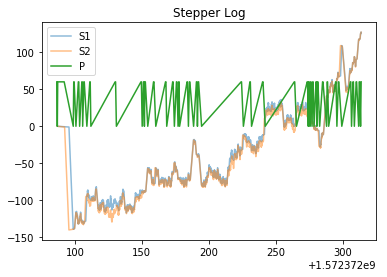

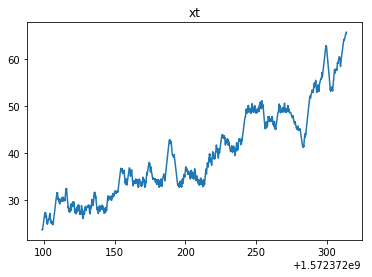

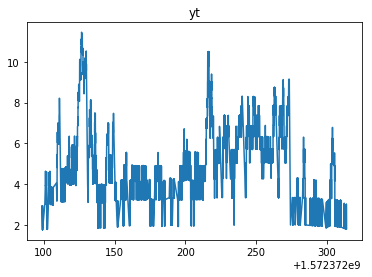

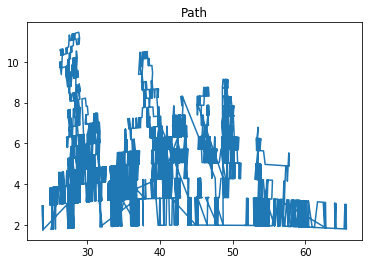

In [191]:
pl.plot_paths()